# Diffprivlib Experiment: Gaussian Naiive Bayes
---
<b>Author: A.Krauskopf<b><br>
<b>Last Update: 29 Oct 2024<b>

This notebook includes the iterative experiment code and figure creation focusing on both non-differentially private and differentially private instances of the gaussian naiive bayes classification method. This depends upon the .csv files referenced to reside in the datasets subfolder in the same directory as this notebook. It also requires a figures subfolder for the resulting imagery to be saved to.

<b>Package Prerequisites:<b>
- pandas
- numpy
- matplotlib
- joblib
- tqdm
- sklearn
- diffprivlib

<b>Other Notebooks:<b>
- Random Forest (Diffprivlib Experiment-RF.ipynb)
- Logistic Regression (Diffprivlib Experiment-LR.ipynb)

### 1: Setup

In [56]:
# Import necessary packages
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.naive_bayes import GaussianNB
import diffprivlib as dp
import time

In [57]:
# Setup dataframe to hold timing statistics
nb_runtime = pd.DataFrame(columns=['Setup', 'Validate', 'Baseline', 'Compare'], index=['Start Time', 'End Time', 'Runtime'])

# Capture start time
nb_runtime.loc['Start Time', 'Setup'] = time.time()

In [58]:
# Open and read the data into a dataframe
train = pd.read_csv('../datasets/fraudTrain_clean.csv', index_col=0)
test = pd.read_csv('../datasets/fraudTest_clean.csv', index_col=0)

# Split into dependent and independent variables
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

In [59]:
# Additional requirements specific to DP-NB

# Calculate the bounds
total = pd.concat([train, test], ignore_index=True, sort=False)
min_values = total.min().tolist()[:-1]
max_values = total.max().tolist()[:-1]
bounds = (min_values, max_values)
print(bounds)

nb_runtime.loc['End Time', 'Setup'] = time.time()

([0.0, -1.0, 1.0, -1.0, 1257.0, 23.0, -1.0, 19.0, 0.0, 0.0, 0.0, 0.0, 12.7], [988.0, 1.0, 28948.9, 1.0, 99921.0, 2906700.0, 1.0, 99.0, 6.0, 23.0, 13.0, 2.0, 948.818181818182])


### 2: Verify DP(ε =∞) = non-private scikit learn

In [60]:
nb_runtime.loc['Start Time', 'Validate'] = time.time()

# Compare the baseline non-DP to DP @ infinity value
num_runs = 30
nb_noDP_mcc_list = []
nb_DP_mcc_list = []

for run in tqdm(range(num_runs)):
    nb_noDP = GaussianNB()
    nb_noDP.fit(X_train, y_train)
    y_pred_nb_noDP = nb_noDP.predict(X_test)
    nb_noDP_mcc_list.append(matthews_corrcoef(y_test, y_pred_nb_noDP))

    nb_DP = dp.models.GaussianNB(epsilon=np.inf, random_state=(42 + run), bounds=bounds)
    nb_DP.fit(X_train, y_train)
    y_pred_nb_DP = nb_DP.predict(X_test)
    nb_DP_mcc_list.append(matthews_corrcoef(y_test, y_pred_nb_DP))

# Convert list to numpy arrays
nb_noDP_mcc_list = np.array(nb_noDP_mcc_list)
nb_DP_mcc_list = np.array(nb_DP_mcc_list)

print("noDP MCC: ", nb_noDP_mcc_list.mean())
print("DP(e=inf) MCC: ", nb_DP_mcc_list.mean())

nb_runtime.loc['End Time', 'Validate'] = time.time()

100%|█████████████████████████████████████| 30/30 [00:20<00:00,  1.47it/s]

noDP MCC:  0.7495857296114815
DP(e=inf) MCC:  0.7503816721120157


### 3: Baseline DP-NB

In [61]:
nb_runtime.loc['Start Time', 'Baseline'] = time.time()

# Define the data for the first graph

# Define the range of epsilon values including infinity
epsilons = np.logspace(-2, 2, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

DPnb_mcc_rows = []

for run in tqdm(range(num_runs)):
    for epsilon in epsilons:
        DPnb = dp.models.GaussianNB(epsilon=epsilon, random_state=(42 + run), bounds=bounds)
        DPnb.fit(X_train, y_train)
        y_pred_DPnb = DPnb.predict(X_test)
        DPnb_mcc_rows.append(
            {
                "epsilon": epsilon,
                "run": run,
                "mcc": matthews_corrcoef(y_test, y_pred_DPnb),
            }
        )

# Convert data to dataframe and average across all runs
DPnb_mcc_df = pd.DataFrame(DPnb_mcc_rows).set_index("epsilon")
grouped_mcc = DPnb_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_nb_noDP_mcc = grouped_mcc[np.inf]
avg_DPnb_mcc = grouped_mcc.iloc[:-1]

print(avg_DPnb_mcc)
nb_runtime.loc['End Time', 'Baseline'] = time.time()

100%|█████████████████████████████████████| 30/30 [09:34<00:00, 19.15s/it]

epsilon
0.010000      0.426404
0.012068      0.458676
0.014563      0.529945
0.017575      0.543033
0.021210      0.577410
0.025595      0.635035
0.030888      0.610405
0.037276      0.645680
0.044984      0.632658
0.054287      0.683933
0.065513      0.682544
0.079060      0.678204
0.095410      0.696381
0.115140      0.714542
0.138950      0.716602
0.167683      0.690518
0.202359      0.676896
0.244205      0.691522
0.294705      0.743419
0.355648      0.700893
0.429193      0.720921
0.517947      0.703712
0.625055      0.726032
0.754312      0.729811
0.910298      0.714332
1.098541      0.680694
1.325711      0.698442
1.599859      0.736285
1.930698      0.751659
2.329952      0.755162
2.811769      0.760330
3.393222      0.759464
4.094915      0.758992
4.941713      0.758330
5.963623      0.755469
7.196857      0.755206
8.685114      0.761993
10.481131     0.747282
12.648552     0.745562
15.264180     0.748850
18.420700     0.753048
22.229965     0.752206
26.826958     0.767647
32.

In [62]:
#Output min and max from the baseline data

# Get the minimum and maximum epsilon values (index)
epsilon_min = avg_DPnb_mcc.index.min()
epsilon_max = avg_DPnb_mcc.index.max()

# Get the minimum and maximum MCC values (values of the Series)
mcc_min = avg_DPnb_mcc.min()
mcc_max = avg_DPnb_mcc.max()

# Output the results
print("Minimum epsilon:", epsilon_min)
print("Maximum epsilon:", epsilon_max)
print("Minimum MCC:", mcc_min)
print("Maximum MCC:", mcc_max)

Minimum epsilon: 0.01
Maximum epsilon: 100.0
Minimum MCC: 0.4264039777955342
Maximum MCC: 0.7676473288487385


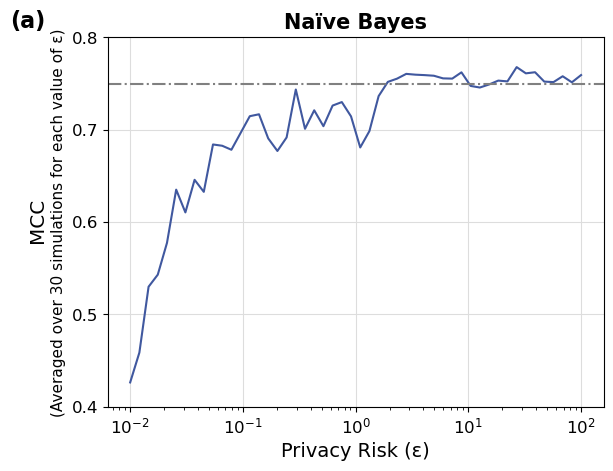

In [89]:
# Create the figure with the specified size
fig_nb1 = plt.figure(figsize=(6.4, 4.8))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPnb_mcc, color='#40589F', label="Differentially Private") # :-1 when infinity is included
plt.axhline(y=nb_noDP_mcc_list.mean(), color='grey', linestyle='-.', label="Non-Private")

plt.title("Naïve Bayes", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_nb1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.4, 0.85, 0.1))
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(a)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/NB-Graph4-old.png', dpi=600, bbox_inches='tight')
plt.show()

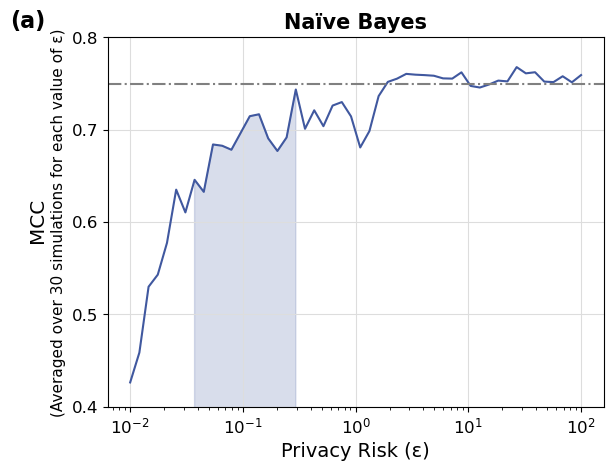

In [130]:
# Create the figure with the specified size
fig_nb1 = plt.figure(figsize=(6.4, 4.8))

# Plot the main line
plt.semilogx(epsilons[:-1], avg_DPnb_mcc, color='#40589F', label="Differentially Private")  # Use epsilons[:-1] if needed
plt.axhline(y=nb_noDP_mcc_list.mean(), color='grey', linestyle='-.', label="Non-Private")

# Define the bounds for x values
x_lower, x_upper = 0.031, 0.3

# Find the indices where epsilons fall within the specified x range
x_mask = (epsilons[:-1] >= x_lower) & (epsilons[:-1] <= x_upper)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask], 0, avg_DPnb_mcc[x_mask], 
                 where=(avg_DPnb_mcc[x_mask] >= 0), 
                 color='#40589F', alpha=0.2, label="Highlighted Range")

# Plot title and labels
plt.title("Naïve Bayes", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_nb1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.4, 0.85, 0.1))
plt.yticks(fontsize=12)

# Set y-axis limits to clip at 0.4
plt.ylim(0.4, 0.8)  # Set limits to prevent stretching below 0.4

# Add a separate text element
plt.figtext(0, 0.9, "(a)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/NB-Graph4.png', dpi=600, bbox_inches='tight')
plt.show()

### 4: Exploring the impact of imbalance

In [64]:
nb_runtime.loc['Start Time', 'Compare'] = time.time()

# Define data files and parameters
sampledTrain = ['fraudTrain_1%.csv', 'fraudTrain_2%.csv', 'fraudTrain_3%.csv', 
              'fraudTrain_4%.csv', 'fraudTrain_5%.csv', 'fraudTrain_10%.csv',
               'fraudTrain_15%.csv', 'fraudTrain_20%.csv']
colNames = ['1%', '2%', '3%', '4%', '5%', '10%', '15%', '20%']

epsilons = np.logspace(-2, 2, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPnb_sampled_mcc_dict = {}
avg_nb_noDP_sampled_mcc_dict = {}

# Loop through the training and test files
for file, name in tqdm(zip(sampledTrain, colNames), total=len(sampledTrain)):

    # Load the datasets
    sampledData = pd.read_csv(f'../datasets/{file}')  # Test established previously
    X_train_sampled = sampledData.drop(['is_fraud'], axis=1)
    y_train_sampled = sampledData['is_fraud']

    # Empty list for the loop to fill
    dpnb_mcc_sampled_rows = []
    
    for run in tqdm(range(num_runs), desc=f"Runs for {name}"):
        for epsilon in epsilons:
            DPnb_sampled = dp.models.GaussianNB(epsilon=epsilon, random_state=(42 + run), bounds=bounds)
            DPnb_sampled.fit(X_train_sampled, y_train_sampled)
            y_pred_DPnb_sampled = DPnb_sampled.predict(X_test) # Test established previously
            dpnb_mcc_sampled_rows.append( 
                {
                    "epsilon": epsilon,
                    "run": run,
                    "mcc": matthews_corrcoef(y_test, y_pred_DPnb_sampled), 
                } 
            ) # Test established previously

    # Convert data to dataframe
    dpnb_mcc_sampled_df = pd.DataFrame(dpnb_mcc_sampled_rows)
    #dpnb_mcc_sampled_df = pd.DataFrame(dpnb_mcc_sampled_rows).set_index("epsilon")

    # Compute the average MCC across all runs
    grouped_mcc_sampled = dpnb_mcc_sampled_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_nb_noDP_sampled_mcc = grouped_mcc_sampled[np.inf]
    avg_DPnb_sampled_mcc = grouped_mcc_sampled.iloc[:-1]
   
    # Store the resulting dataframe in the dictionary
    avg_nb_noDP_sampled_mcc_dict[name] = avg_nb_noDP_sampled_mcc
    avg_DPnb_sampled_mcc_dict[name] = avg_DPnb_sampled_mcc

# Access the resulting dataframes using avg_DPnb_mcc_dict
print('Complete')

100%|████████████████████████████████████| 8/8 [1:14:57<00:00, 562.22s/it]

Complete


In [65]:
# Add previously calculated baseline runs to the dictionaries
avg_nb_noDP_sampled_mcc_dict['Baseline'] = nb_noDP_mcc_list.mean()
avg_DPnb_sampled_mcc_dict['Baseline'] = avg_DPnb_mcc

#print(avg_nb_noDP_sampled_mcc_dict)
#print(avg_DPnb_sampled_mcc_dict)

nb_runtime.loc['End Time', 'Compare'] = time.time()

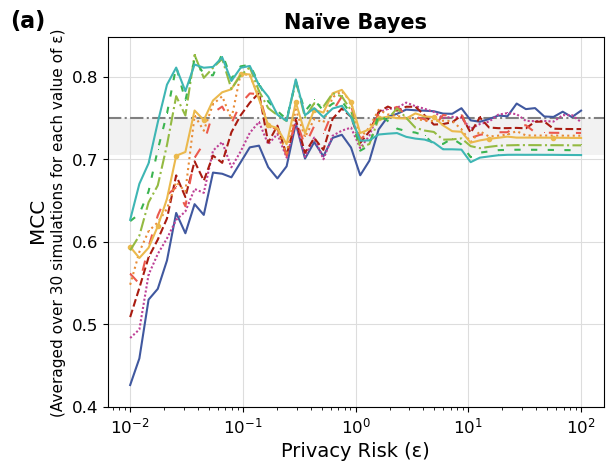

In [66]:
# Create the figure with the specified size
fig_nb2 = plt.figure(figsize=(6.4, 4.8))

# Plot the non-DP sampled values
plt.axhline(y=avg_nb_noDP_sampled_mcc_dict['Baseline'], color='grey', linestyle='-.', label="Non-DP Baseline")

nb_MCC_min = min(avg_nb_noDP_sampled_mcc_dict.values())
nb_MCC_max = max(avg_nb_noDP_sampled_mcc_dict.values())
plt.axhspan(nb_MCC_max, nb_MCC_min, facecolor='silver', alpha=0.2, label="Non-Private sampled Range")

# Plot the results from plot 1
plt.semilogx(epsilons[:-1], avg_DPnb_sampled_mcc_dict['Baseline'], color='#40589F', label="Baseline (π < 1%}")

# Add the sampled lines for comparison
colors = ['#BE4196', '#A91C11', '#EB594D', '#E88C38', '#EBB94D', '#94BA42', '#3BB450', '#3EB6B4']
#colors = ['#BE4196', '#EB594D', '#E88C38', '#EBB94D', '#3EB6B4', '#94BA42']
labels = ['π = 1%', 'π = 2%', 'π = 3%', 'π = 4%', 'π = 5%', 'π = 10%', 'π = 15%', 'π = 20%']
widths = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5 ]
styles = [(0, (1, 1)), '--', (0, (5, 8)), ':', '-', '-.', (0, (3, 5)), '-' ]
markers= [",", ",", ",", ",", ".", ",", ",", ","] 

for name, color, label, width, style, marker in zip(colNames[:], colors, labels, widths, styles, markers):
    plt.semilogx(epsilons[:-1], avg_DPnb_sampled_mcc_dict[name], color=color, label=label, linewidth=width, 
                 linestyle=style, marker=marker, markevery=.1)

plt.title("Naïve Bayes", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_nb2.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.4, 0.85, 0.1))
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(a)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/NB-Graph5.png', dpi=600, bbox_inches='tight')
plt.show()

In [67]:
# Calculate Runtimes
nb_runtime.loc['Runtime'] = nb_runtime.loc['End Time'] - nb_runtime.loc['Start Time']

# Output Runtime data
nb_runtime

,Setup,Validate,Baseline,Compare
Start Time,1730755217.311941,1730755218.514886,1730755238.947886,1730755814.008092
End Time,1730755218.483823,1730755238.942751,1730755813.36593,1730760311.773091
Runtime,1.171882,20.427865,574.418044,4497.764999


In [92]:
print(avg_DPnb_sampled_mcc_dict['20%'])

epsilon
0.010000      0.626668
0.012068      0.670338
0.014563      0.695163
0.017575      0.744865
0.021210      0.790551
0.025595      0.811261
0.030888      0.782702
0.037276      0.814956
0.044984      0.811066
0.054287      0.812009
0.065513      0.823686
0.079060      0.795012
0.095410      0.810984
0.115140      0.813227
0.138950      0.789868
0.167683      0.775973
0.202359      0.754139
0.244205      0.746713
0.294705      0.796915
0.355648      0.753468
0.429193      0.761989
0.517947      0.751191
0.625055      0.761614
0.754312      0.764856
0.910298      0.751388
1.098541      0.722612
1.325711      0.723034
1.599859      0.730107
1.930698      0.731111
2.329952      0.731848
2.811769      0.727268
3.393222      0.725135
4.094915      0.723942
4.941713      0.720338
5.963623      0.712194
7.196857      0.712168
8.685114      0.711791
10.481131     0.696599
12.648552     0.702065
15.264180     0.703548
18.420700     0.704968
22.229965     0.705496
26.826958     0.705551
32.

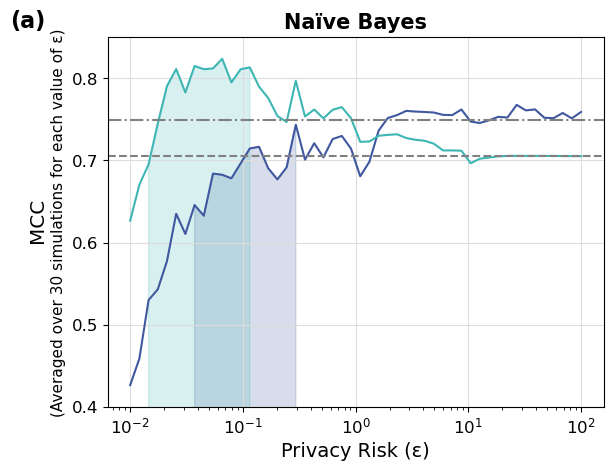

In [157]:
# Baseline to 20% imbalance comparison

# Create the figure with the specified size
fig_nb3 = plt.figure(figsize=(6.4, 4.8))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPnb_mcc, color='#40589F', label="Baseline (π < 1%}") # :-1 when infinity is included
plt.semilogx(epsilons[:-1], avg_DPnb_sampled_mcc_dict['20%'], color='#3eb6B4', label="π = 20%")

# Define the bounds for x values
x_lower_nbb, x_upper_nbb = 0.031, 0.3
x_lower_nb20, x_upper_nb20 = 0.014, 0.12

# Find the indices where epsilons fall within the specified x range
x_mask_nbb = (epsilons[:-1] >= x_lower_nbb) & (epsilons[:-1] <= x_upper_nbb)
x_mask_nb20 = (epsilons[:-1] >= x_lower_nb20) & (epsilons[:-1] <= x_upper_nb20)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask_nbb], 0, avg_DPnb_mcc[x_mask_nbb], 
                 where=(avg_DPnb_mcc[x_mask_nbb] >= 0), 
                 color='#40589F', alpha=0.2, label="Highlighted Range")

plt.fill_between(epsilons[:-1][x_mask_nb20], 0, avg_DPnb_sampled_mcc_dict['20%'][x_mask_nb20], 
                 where=(avg_DPnb_sampled_mcc_dict['20%'][x_mask_nb20] >= 0), 
                 color='#3eb6B4', alpha=0.2, label="Highlighted Range")


# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [nb_noDP_mcc_list.mean(), avg_nb_noDP_sampled_mcc_dict['20%']],
    ['grey', 'grey'],
    ['-.', '--'],
    ["Non-Private Baseline", "Non-Private 20% sampled"])
]

plt.title("Naïve Bayes", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_nb3.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set y-axis limits to clip at 0.4
plt.ylim(0.4, 0.85)  # Set limits to prevent stretching below 0.4

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.4, 0.85, 0.1))
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(a)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/NB-Graph6.png', dpi=600, bbox_inches='tight') 
plt.show()

In [144]:
print(nb_MCC_min)

0.704989545427993
